In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
%matplotlib inline 

In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [4]:
# 配置权重文件，用cpu或gpu加速，以及分割模型
sam_checkpoint = "/Users/hsh/OpenCV practise/SAM seg demo/weights/sam_vit_h_4b8939.pth"
device = "cpu"
model_type = "default"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

In [135]:
# 选择要处理的图片
image_file_name = r"image/IL-G2.jpg"
image = cv2.imread(image_file_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
masks = mask_generator.generate(image)

# print(len(masks))
# print(masks[0].keys())

In [136]:
# 输入标尺像素个数、标尺代表的物理长度
pixel_distance = 189
physic_distance = 5   # 单位：μm

segments, areas = [], []
contour_area, contour_len = [], []
for mask in masks:
    segments.append(mask['segmentation'])
    mask_seg8 = mask['segmentation'].astype(np.uint8)
    contours, _ = cv2.findContours(mask_seg8, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour_area.append(cv2.contourArea(contours[0]))
    contour_len.append(cv2.arcLength(contours[0], True))
    areas.append(mask['area'])

stati = np.concatenate([np.array(areas).reshape(len(masks),1), np.array(contour_area).reshape(len(masks),1), np.array(contour_len).reshape(len(masks),1)],axis=1)
stati = pd.DataFrame(stati, columns=['area','cv2_area', 'cv2_length'])
# 用segment-anything的model计算的面积进行换算，分别以圆形和正方形计算尺寸大小
stati.insert(3, 'circle_dia/um', stati['area'].apply(lambda x: round(np.sqrt(x/np.pi)/pixel_distance*2*physic_distance,1)))
stati.insert(4, 'square_dia/um', stati['area'].apply(lambda x: round(np.sqrt(x)/pixel_distance*physic_distance,1)))
stati.drop([0,1], axis = 0, inplace = True)         # 当图片中包含比例尺时执行此行(用drop删除前两个mask，第一个mask是背景，第二个mask是比例尺)
# 统计均值、标准偏差、D50、D90、D99，保存于stati_data中
stati_data = round(pd.concat([stati.mean(), stati.std(), stati.median(), stati.quantile(0.9), stati.quantile(0.99)], axis=1).T, 1)
stati_data.index = ['average', 'standardization', 'D50', 'D90', 'D99']
stati, stati_data

(      area  cv2_area  cv2_length  circle_dia/um  square_dia/um
 2    902.0     842.5  138.124890            0.9            0.8
 3   1397.0    1323.5  169.438599            1.1            1.0
 4   1278.0    1212.0  154.024384            1.1            0.9
 5   1756.0    1679.5  176.267026            1.3            1.1
 6   3202.0    3085.5  264.551297            1.7            1.5
 ..     ...       ...         ...            ...            ...
 65   212.0     187.0   52.970562            0.4            0.4
 66   370.0     335.5   79.840620            0.6            0.5
 67   151.0     111.5   83.213203            0.4            0.3
 68    31.0      22.5   17.899495            0.2            0.1
 69  3294.0       0.0    0.000000            1.7            1.5
 
 [68 rows x 5 columns],
                    area  cv2_area  cv2_length  circle_dia/um  square_dia/um
 average          1544.4    1423.1       152.7            1.0            0.9
 standardization  2037.6    1991.6       114.5      

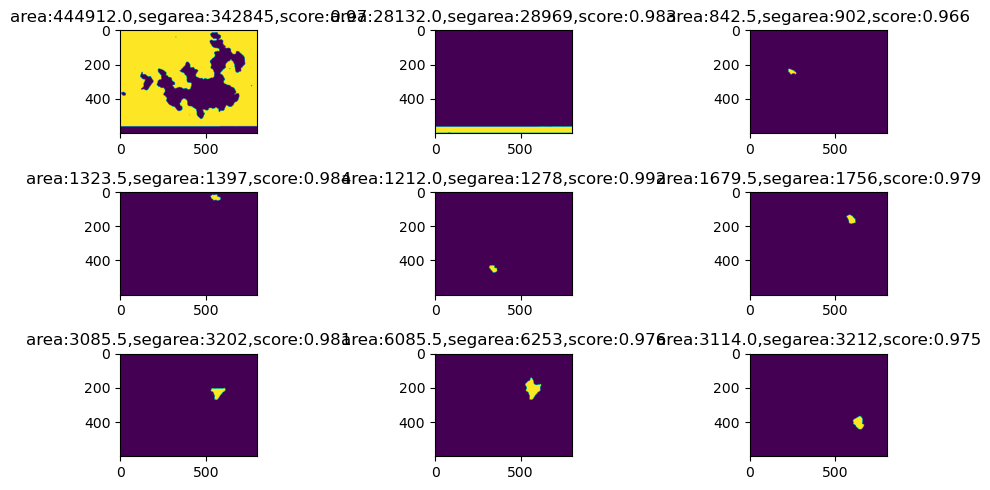

In [137]:
# 展示分割得到的mask
fig, axs = plt.subplots(3, 3, figsize=(10,5))
for i,mask in enumerate(masks[:9]):
    mask_seg = mask['segmentation']
    mask_seg8 = mask_seg.astype(np.uint8)
    contours, _ = cv2.findContours(mask_seg8, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    area = cv2.contourArea(contours[0])
    ax = axs[i//3, i%3] 
    ax.imshow(mask_seg)
    ax.set_title('area:{0},segarea:{1},score:{2}'.format(area,round(mask['area']),round(mask['stability_score'],3)))
    
plt.tight_layout()
plt.show()

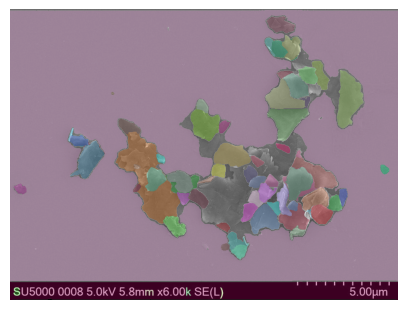

In [138]:
# 显示分割后的图
plt.figure(figsize=(5,5))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

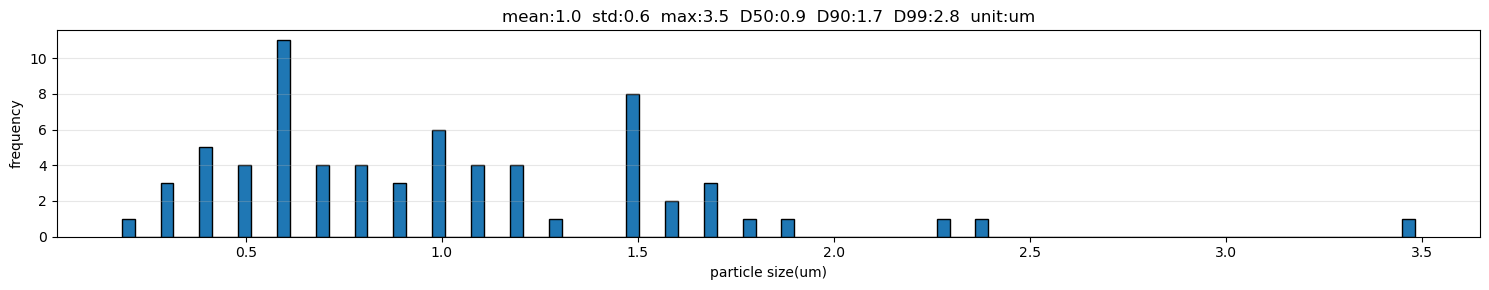

In [147]:
# 绘制尺径分布图
plt.figure(figsize=(15, 3))
hist, bins = np.histogram(stati['circle_dia/um'], bins=100)
plt.bar(bins[:-1], hist, width=np.diff(bins), ec='k')

plt.title('mean:{}  std:{}  max:{}  D50:{}  D90:{}  D99:{}  unit:um'.format(stati_data['circle_dia/um'][0],stati_data['circle_dia/um'][1],stati['circle_dia/um'].max(),stati_data['circle_dia/um'][2],stati_data['circle_dia/um'][3],stati_data['circle_dia/um'][4])) 
plt.grid(axis='y', alpha=0.3)
plt.xlabel('particle size(um)')
plt.ylabel('frequency')
plt.tight_layout()
plt.show()

In [143]:
# 保存分割结果
export_path = 'export_data'
file_name = image_file_name.split('/')[-1].split('.')[0]
stati.to_csv(export_path+'/'+file_name+'_particle.csv', index=False)            # 粒径分布结果
stati_data.to_csv(export_path+'/'+file_name+'_statistics.csv', index=True)      # 统计结果